## Business Overview

The holidays can be a little awkard with Uncle Joe quoting Tucker Carlson and Aunt Georgina replying with a Rachel Madow quote. Or equally awkward conversations starting off "Well I heard on CNN.." or "On Brietbart they said.." These aren't just conversation around the dinner table, these discussionss are going on around the country. While it is easy to identify those media sources bias due to the size. There are smaller and more indepedent newsources where a reader may not know the news source's bias. These news sources can appear in news feeds based on whatever social media site's algrothim decides. 
<br><br>
The good people at allsides.com try to help people "easily identify different perspectives so you can get the full picture and think for yourself." Today's media is very biased. And a lot of media sources are very acessible.  People's newsfeeds are often an echo chamber based on thier history of related articles and newsites. By nature, echo chambers remove media sources outside of someone's chamber, making it difficult to understand different view points regarding news events. 
<br><br>
By knowing a media source's bias, the reader can critically think about what the article is presenting. Know what words and terms determine bias creates trasparency about topics in the article. For example, the reader can know certain words and phrases are used in different biased articles and go deeper into the article to think about why the author used the words they did, or what message are they sending by using that word. Helping people become aware of what words and phrases drive bias in news media content can help the people understand the both sides of an argument. 
<br><br>People who do want to explore both side of an argument may visit a site like AllSides.com to guage a news site's bias. Allsides uses many methods to rate bias, including third party data with the requirement of transparency in the system. I have developed a model to determine bias in a corpus of news articles. To add transparency and explainability to my model I have utilized LIME to show what words and phrases leading to a better understanding of media bias and more informed readers

## Data Understanding

Source:
I would have liked to use one dataset, however, the computational cost was too high which lead me to shrinking the size of the dataset. This dataset was gathered by from https://components.one/datasets/all-the-news-2-news-articles-dataset/ and https://www.kaggle.com/snapcrack/all-the-news. The Kaggle dataset was created from the original source site but different for a different database. The dataframes contained the same content and allowed me to use information from both to develop the working DataFrame.<br><br>
I began by looking at the data and understanding I would only be able to predict left, center or right. I did not have enough data to make a 5 class predictor. From there I decided to select two left foused, two center focused and two right focused media outlets. The news sources were determined by looking at MediaBias/Fact Check and Allsides.com Media Bias lists and selecting sources that each independent side agreed on. After selecting my sources, I began to gather the articles in one DataFrame.<br><br>
I decided to go with sources for each category of bias. The sources do not have an equal number of articles. And each bias is not an equal split. The Kaggle Dataset had all of the information I needed for the right leaning articles. I had to use the other dataset to pull stories from Vox and The Hill. To maintain class balance, I randomly select between 16,000 and 17,000 texts pulished on The Hill's website. In total, I gathers 85,000 articles from from the two datasets. Each row contains an article, publisher and bias label. For modeling I will use the article and bias.
<br><br>
This data set could be used to its full potential with better computing power. The article corous also has a limited amount of right leaning news sources. There is an abundance of left leaning sources. With a greater variety of sources, I would like to expand this classifer.

In [57]:
#import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from itertools import islice

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from  nltk import FreqDist
import re
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical


In [2]:
#take engineered dataframe from pickle 
df = pd.read_pickle("../data/df.pkl")
df.head()

,Publication,Content,Bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left
1,CNN,Atlanta (CNN) This season’s College Football P...,Left
2,CNN,(CNN) Revelers on the United States’ west coa...,Left
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left
4,CNN,(CNN) Two small planes collided in Texas on S...,Left


In [3]:
#check the shape of the data
df.shape

(85365, 3)

In [4]:
#is anything null?
df.isna().sum()

Publication    0
Content        1
Bias           0
dtype: int64

In [5]:
#deop null rolls
df.dropna(inplace=True)

In [6]:
#Sanity check
df.isna().sum()

Publication    0
Content        0
Bias           0
dtype: int64

In [7]:
#How many atcles per publication?
df["Publication"].value_counts()

Breitbart          23781
The Hill           16811
Vox                16371
CNN                11488
Reuters            10710
National Review     6203
Name: Publication, dtype: int64

In [8]:
#How many atcles per Bias?
df["Bias"].value_counts()

Right     29984
Left      27859
Center    27521
Name: Bias, dtype: int64

In [9]:
print("Percentage of Articles per Bias in Dataset:")
df["Bias"].value_counts(normalize=True)*100

Percentage of Articles per Bias in Dataset:


Right     35.124877
Left      32.635537
Center    32.239586
Name: Bias, dtype: float64

### Visualize the data

In [10]:
def countplot(df, col, hue=None, rotation=None, order=None):
    """
    This function builds a Seaborn countplot and allows the user to set certain parameters to customize the graph.
    
    df - dataframe being used
    col- column in dataframe being used
    hue - second column being used(if any)
    rotation - sets the rotation of the x-ticks for readability
    """
    fig, ax = plt.subplots(figsize=(12,8))
    sns.countplot(data = df, x = col, hue = hue, order = order)
    ax.set_xticklabels(labels = ax.get_xticklabels(), rotation= rotation, fontsize = 15)
    ax.set_xlabel(xlabel = col, fontsize = 20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
    ax.set_title(f"Number of articles per {col}", fontsize = 30)
    plt.show()

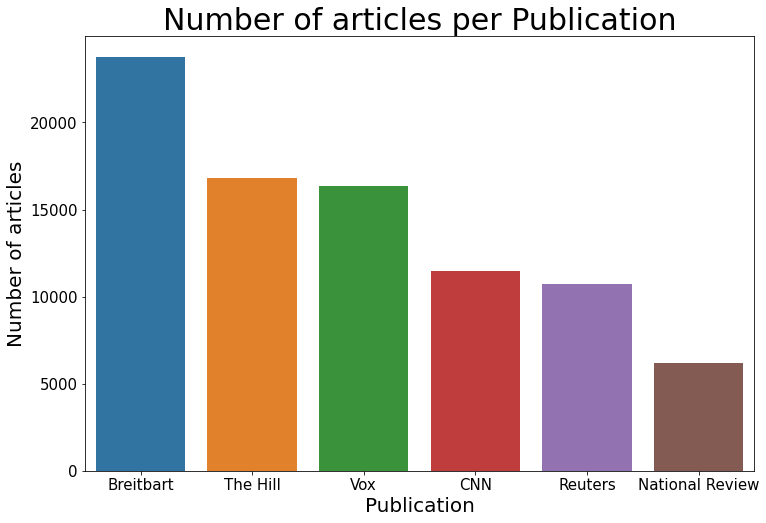

In [11]:
#number of articles per publication
countplot(df, "Publication", order = df["Publication"].value_counts().index)

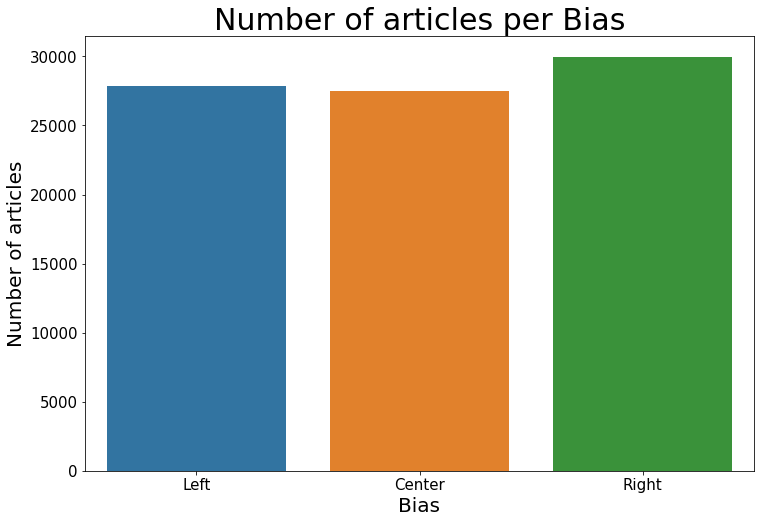

In [12]:
#number of articles per publication
countplot(df, "Bias", order = ["Left", "Center", "Right"])

In [13]:
#group 
df_plot = df.groupby(['Publication', 'Bias']).size().reset_index().pivot(columns='Publication', index='Bias', values=0)

In [14]:
df_plot = df_plot.reindex(["Left", "Center", "Right"])

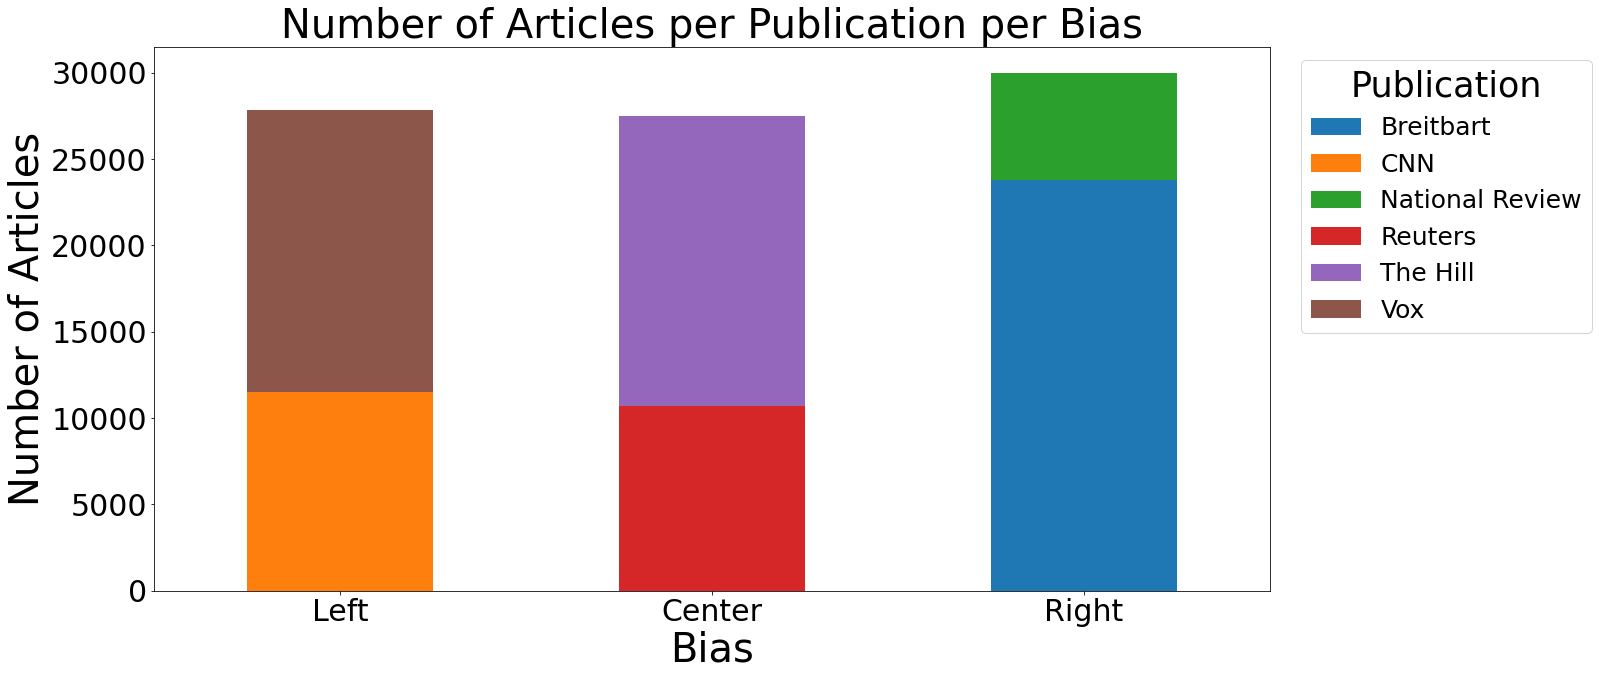

In [15]:
df_plot.plot(kind='bar', stacked=True, figsize=(20,10))
plt.xticks(rotation="horizontal", fontsize = 30)
plt.xlabel(xlabel = "Bias", fontsize = 40)
plt.yticks(rotation="horizontal", fontsize = 30)
plt.ylabel(ylabel = "Number of Articles", fontsize = 40)
plt.title(label= "Number of Articles per Publication per Bias", fontsize = 40)
plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", ncol=1, fontsize= 25, title = "Publication", title_fontsize= 35)
plt.show()

In [ ]:
df['word_count'] = df["Content"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
df['char_count'] = df["Content"].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
df['sentence_count'] = df["Content"].apply(lambda x: len(nltk.sent_tokenize(str(x))) )

In [ ]:
df

## Data Prep

I went through a series of operations to preprocess the data for Machine Learning. The first step was to encode the bias with a 0 for left, 1 for center and 2 for right. <br>
<br>
Each article will run through a function that will:
1. Lower case each word
2. Remove unwanted noise from the article(such as Twitter mentions, web adresses and other content)
3. Remove all numbers
4. Tokenize the list
5. Remove common stop words and punctuation
6. Lemmatizes each word 
7. Returns a string of the remaining lemmatized words.

### Preprocessing Data

In [16]:
#check the data set
df

,Publication,Content,Bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left
1,CNN,Atlanta (CNN) This season’s College Football P...,Left
2,CNN,(CNN) Revelers on the United States’ west coa...,Left
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left
4,CNN,(CNN) Two small planes collided in Texas on S...,Left
...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right
85361,National Review,Whether it’s celebrated according to the Grego...,Right
85362,National Review,Editor’s Note: This piece first appeared in th...,Right
85363,National Review,Israel would seem to be in a disastrous positi...,Right


In [17]:
# Multiclass the bias column
dict_sent = {'Left':0, 
             'Center':1,
             'Right':2}
df["num_bias"] = df["Bias"].map(dict_sent)

Check all three labels

In [18]:
df.head()

,Publication,Content,Bias,num_bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,0
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,0
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,0
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,0
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,0


In [19]:
df.iloc[45000:45005]

,Publication,Content,Bias,num_bias
45001,The Hill,Rep. Al GreenAlexander (Al) N. GreenWe need a ...,Center,1
45002,The Hill,View the discussion thread. The Hill 1625 K St...,Center,1
45003,The Hill,Rep. Al GreenAlexander (Al) N. GreenWe need a ...,Center,1
45004,The Hill,The public health community has been closely w...,Center,1
45005,The Hill,One of the contributing factors that led to Do...,Center,1


In [20]:
df.tail()

,Publication,Content,Bias,num_bias
85360,National Review,I first read Thomas Sowell in college — no ...,Right,2
85361,National Review,Whether it’s celebrated according to the Grego...,Right,2
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,2
85363,National Review,Israel would seem to be in a disastrous positi...,Right,2
85364,National Review,The year 2016 was a good one for books by men ...,Right,2


In [21]:
#initialize the Tokenizer and Lemmatizer
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
lemma = WordNetLemmatizer()

I decided to remove the news source to prevent a directe correlation between the name and bias. I want the models to focus on words and context not tied to the news source.

In [22]:
# Create a list of new sources to add to stopwords list
source = list(df["Publication"].unique())
source = (map(lambda x: x.lower(), source))
source = list(source)
source

['cnn', 'vox', 'reuters', 'the hill', 'breitbart', 'national review']

In [23]:
#create stopwords_list, adds punctuation and the news sources to list
stopwords_list = stopwords.words("english")
stopwords_list += string.punctuation
stopwords_list += source
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
#random article in the corpus will use to check the preprocessing step
test = df["Content"].iloc[random.randint(0,df.shape[0])]
test

' (CNN) The man who authorities say shot two people, killing one, on a bus in Las Vegas surrendered without incident Saturday after a standoff that lasted more than four hours, police spokesman Larry Hadfield told reporters.  Hadfield said the second person shot had minor injuries and was hospitalized. Rolando Cardenas, 55, was charged with open murder with use of a firearm, attempted murder with use of a firearm, burglary while in possession of a firearm and discharging a gun within a vehicle, police said in a news release issued Sunday. The release said the victims and Cardenas were sitting in rear of the bus. When the bus stopped and passengers began to disembark, Cardenas stood up and fired several rounds with a handgun ”for no apparent reason,” the statement said. Cardenas remained on the coach bus for hours while tactical teams and negotiators came to the scene on Las Vegas Boulevard, which was closed between Flamingo Road and Tropicana Boulevard during the crisis, police said. A

In [25]:
#lowercase text
test = test.lower()
test

' (cnn) the man who authorities say shot two people, killing one, on a bus in las vegas surrendered without incident saturday after a standoff that lasted more than four hours, police spokesman larry hadfield told reporters.  hadfield said the second person shot had minor injuries and was hospitalized. rolando cardenas, 55, was charged with open murder with use of a firearm, attempted murder with use of a firearm, burglary while in possession of a firearm and discharging a gun within a vehicle, police said in a news release issued sunday. the release said the victims and cardenas were sitting in rear of the bus. when the bus stopped and passengers began to disembark, cardenas stood up and fired several rounds with a handgun ”for no apparent reason,” the statement said. cardenas remained on the coach bus for hours while tactical teams and negotiators came to the scene on las vegas boulevard, which was closed between flamingo road and tropicana boulevard during the crisis, police said. a

In [26]:
#Regex expressions to remove unwanted noise
pattern_mentions = "((@[a-zA-Z0-9_-]+)((?=\s+)|$|[!?.,-]))"
pattern_views =  "((the views expressed by)([\s\S]*)$)"
pattern_thread = "((view the discussion thread.)([\s\S]*)$)"
pattern_url = "(http\S+)"
pattern_num = "([\d.])"
pattern_pic = "((pic.)?twitter\.com\/[A-Za-z0-9_]{5,1000}(\?(\w+=\w+&?)*)?)"

In [27]:
# Removes Twitter mentions
test = re.sub(pattern_mentions,"", test)
test

' (cnn) the man who authorities say shot two people, killing one, on a bus in las vegas surrendered without incident saturday after a standoff that lasted more than four hours, police spokesman larry hadfield told reporters.  hadfield said the second person shot had minor injuries and was hospitalized. rolando cardenas, 55, was charged with open murder with use of a firearm, attempted murder with use of a firearm, burglary while in possession of a firearm and discharging a gun within a vehicle, police said in a news release issued sunday. the release said the victims and cardenas were sitting in rear of the bus. when the bus stopped and passengers began to disembark, cardenas stood up and fired several rounds with a handgun ”for no apparent reason,” the statement said. cardenas remained on the coach bus for hours while tactical teams and negotiators came to the scene on las vegas boulevard, which was closed between flamingo road and tropicana boulevard during the crisis, police said. a

The Hill articles end with "the views expressed by" or "view the discussion thread" both are followed by some contact information. I decided to remove these elements to prevent mis weighing words later in the Vectorizing stage of the project.

In [28]:
# remove the end of The Hill articles starting at the phrase "the views expressed by"
test =  re.sub(pattern_views,"", test)
test

' (cnn) the man who authorities say shot two people, killing one, on a bus in las vegas surrendered without incident saturday after a standoff that lasted more than four hours, police spokesman larry hadfield told reporters.  hadfield said the second person shot had minor injuries and was hospitalized. rolando cardenas, 55, was charged with open murder with use of a firearm, attempted murder with use of a firearm, burglary while in possession of a firearm and discharging a gun within a vehicle, police said in a news release issued sunday. the release said the victims and cardenas were sitting in rear of the bus. when the bus stopped and passengers began to disembark, cardenas stood up and fired several rounds with a handgun ”for no apparent reason,” the statement said. cardenas remained on the coach bus for hours while tactical teams and negotiators came to the scene on las vegas boulevard, which was closed between flamingo road and tropicana boulevard during the crisis, police said. a

In [29]:
# remove the end of The Hill articles starting at the phrase "view the discussion thread"
test =  re.sub(pattern_thread,"", test)
test

' (cnn) the man who authorities say shot two people, killing one, on a bus in las vegas surrendered without incident saturday after a standoff that lasted more than four hours, police spokesman larry hadfield told reporters.  hadfield said the second person shot had minor injuries and was hospitalized. rolando cardenas, 55, was charged with open murder with use of a firearm, attempted murder with use of a firearm, burglary while in possession of a firearm and discharging a gun within a vehicle, police said in a news release issued sunday. the release said the victims and cardenas were sitting in rear of the bus. when the bus stopped and passengers began to disembark, cardenas stood up and fired several rounds with a handgun ”for no apparent reason,” the statement said. cardenas remained on the coach bus for hours while tactical teams and negotiators came to the scene on las vegas boulevard, which was closed between flamingo road and tropicana boulevard during the crisis, police said. a

In [30]:
#removes hyperlinks starting with http
test =  re.sub(pattern_url,"", test)
test

' (cnn) the man who authorities say shot two people, killing one, on a bus in las vegas surrendered without incident saturday after a standoff that lasted more than four hours, police spokesman larry hadfield told reporters.  hadfield said the second person shot had minor injuries and was hospitalized. rolando cardenas, 55, was charged with open murder with use of a firearm, attempted murder with use of a firearm, burglary while in possession of a firearm and discharging a gun within a vehicle, police said in a news release issued sunday. the release said the victims and cardenas were sitting in rear of the bus. when the bus stopped and passengers began to disembark, cardenas stood up and fired several rounds with a handgun ”for no apparent reason,” the statement said. cardenas remained on the coach bus for hours while tactical teams and negotiators came to the scene on las vegas boulevard, which was closed between flamingo road and tropicana boulevard during the crisis, police said. a

Numbers with no context can effect model performance. So I removed all numbers

In [31]:
#removes numbers from the text.
test =  re.sub(pattern_num,"", test)
test

' (cnn) the man who authorities say shot two people, killing one, on a bus in las vegas surrendered without incident saturday after a standoff that lasted more than four hours, police spokesman larry hadfield told reporters  hadfield said the second person shot had minor injuries and was hospitalized rolando cardenas, , was charged with open murder with use of a firearm, attempted murder with use of a firearm, burglary while in possession of a firearm and discharging a gun within a vehicle, police said in a news release issued sunday the release said the victims and cardenas were sitting in rear of the bus when the bus stopped and passengers began to disembark, cardenas stood up and fired several rounds with a handgun ”for no apparent reason,” the statement said cardenas remained on the coach bus for hours while tactical teams and negotiators came to the scene on las vegas boulevard, which was closed between flamingo road and tropicana boulevard during the crisis, police said around : 

In [32]:
#removes pic.twitter urls
test =  re.sub(pattern_pic,"", test)
test

' (cnn) the man who authorities say shot two people, killing one, on a bus in las vegas surrendered without incident saturday after a standoff that lasted more than four hours, police spokesman larry hadfield told reporters  hadfield said the second person shot had minor injuries and was hospitalized rolando cardenas, , was charged with open murder with use of a firearm, attempted murder with use of a firearm, burglary while in possession of a firearm and discharging a gun within a vehicle, police said in a news release issued sunday the release said the victims and cardenas were sitting in rear of the bus when the bus stopped and passengers began to disembark, cardenas stood up and fired several rounds with a handgun ”for no apparent reason,” the statement said cardenas remained on the coach bus for hours while tactical teams and negotiators came to the scene on las vegas boulevard, which was closed between flamingo road and tropicana boulevard during the crisis, police said around : 

In [33]:
#tokenize text
test = tokenizer.tokenize(test)
test

['cnn',
 'the',
 'man',
 'who',
 'authorities',
 'say',
 'shot',
 'two',
 'people',
 'killing',
 'one',
 'on',
 'bus',
 'in',
 'las',
 'vegas',
 'surrendered',
 'without',
 'incident',
 'saturday',
 'after',
 'standoff',
 'that',
 'lasted',
 'more',
 'than',
 'four',
 'hours',
 'police',
 'spokesman',
 'larry',
 'hadfield',
 'told',
 'reporters',
 'hadfield',
 'said',
 'the',
 'second',
 'person',
 'shot',
 'had',
 'minor',
 'injuries',
 'and',
 'was',
 'hospitalized',
 'rolando',
 'cardenas',
 'was',
 'charged',
 'with',
 'open',
 'murder',
 'with',
 'use',
 'of',
 'firearm',
 'attempted',
 'murder',
 'with',
 'use',
 'of',
 'firearm',
 'burglary',
 'while',
 'in',
 'possession',
 'of',
 'firearm',
 'and',
 'discharging',
 'gun',
 'within',
 'vehicle',
 'police',
 'said',
 'in',
 'news',
 'release',
 'issued',
 'sunday',
 'the',
 'release',
 'said',
 'the',
 'victims',
 'and',
 'cardenas',
 'were',
 'sitting',
 'in',
 'rear',
 'of',
 'the',
 'bus',
 'when',
 'the',
 'bus',
 'stopped',

In [34]:
#remove stopwords
stopwords_removed=[token for token in test if token not in stopwords_list]
stopwords_removed

['man',
 'authorities',
 'say',
 'shot',
 'two',
 'people',
 'killing',
 'one',
 'bus',
 'las',
 'vegas',
 'surrendered',
 'without',
 'incident',
 'saturday',
 'standoff',
 'lasted',
 'four',
 'hours',
 'police',
 'spokesman',
 'larry',
 'hadfield',
 'told',
 'reporters',
 'hadfield',
 'said',
 'second',
 'person',
 'shot',
 'minor',
 'injuries',
 'hospitalized',
 'rolando',
 'cardenas',
 'charged',
 'open',
 'murder',
 'use',
 'firearm',
 'attempted',
 'murder',
 'use',
 'firearm',
 'burglary',
 'possession',
 'firearm',
 'discharging',
 'gun',
 'within',
 'vehicle',
 'police',
 'said',
 'news',
 'release',
 'issued',
 'sunday',
 'release',
 'said',
 'victims',
 'cardenas',
 'sitting',
 'rear',
 'bus',
 'bus',
 'stopped',
 'passengers',
 'began',
 'disembark',
 'cardenas',
 'stood',
 'fired',
 'several',
 'rounds',
 'handgun',
 'apparent',
 'reason',
 'statement',
 'said',
 'cardenas',
 'remained',
 'coach',
 'bus',
 'hours',
 'tactical',
 'teams',
 'negotiators',
 'came',
 'scene',


In [35]:
#lemmatize the remaing words
lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
lemma_list

['man',
 'authority',
 'say',
 'shot',
 'two',
 'people',
 'killing',
 'one',
 'bus',
 'la',
 'vega',
 'surrendered',
 'without',
 'incident',
 'saturday',
 'standoff',
 'lasted',
 'four',
 'hour',
 'police',
 'spokesman',
 'larry',
 'hadfield',
 'told',
 'reporter',
 'hadfield',
 'said',
 'second',
 'person',
 'shot',
 'minor',
 'injury',
 'hospitalized',
 'rolando',
 'cardenas',
 'charged',
 'open',
 'murder',
 'use',
 'firearm',
 'attempted',
 'murder',
 'use',
 'firearm',
 'burglary',
 'possession',
 'firearm',
 'discharging',
 'gun',
 'within',
 'vehicle',
 'police',
 'said',
 'news',
 'release',
 'issued',
 'sunday',
 'release',
 'said',
 'victim',
 'cardenas',
 'sitting',
 'rear',
 'bus',
 'bus',
 'stopped',
 'passenger',
 'began',
 'disembark',
 'cardenas',
 'stood',
 'fired',
 'several',
 'round',
 'handgun',
 'apparent',
 'reason',
 'statement',
 'said',
 'cardenas',
 'remained',
 'coach',
 'bus',
 'hour',
 'tactical',
 'team',
 'negotiator',
 'came',
 'scene',
 'la',
 'vega'

In [36]:
#look at distribution of our text content
freq_dist = FreqDist(lemma_list)
freq_dist

FreqDist({'said': 7, 'police': 6, 'bus': 5, 'la': 4, 'vega': 4, 'cardenas': 4, 'incident': 3, 'saturday': 3, 'hadfield': 3, 'firearm': 3, ...})

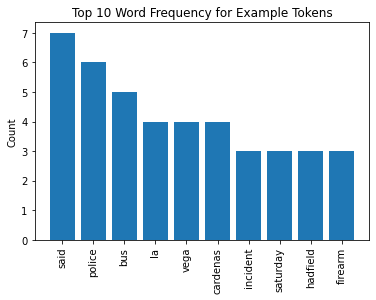

In [37]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_10(freq_dist, "Top 10 Word Frequency for test article")

In [38]:
def preprocess(content):
    """
    This function preprocesses textual data for modeling.
    Steps:
    Lower case each word
    Remove unwanted noise from the article(such as Twitter mentions, web adresses and other content)
    Remove all numbers
    Tokenize the list
    Remove common stop words and punctuation
    Lemmatizes each word
    Returns a string of the remaining lemmatized words.
    
    Content - piece of text to process
    """
    #Turn all the tokens lowercase
    content = content.lower()
    #rmove necessary item from content (see above)
    content = re.sub(pattern_mentions, " ", str(content))
    content = re.sub(pattern_views, " ", str(content))
    content = re.sub(pattern_thread, " ", str(content))
    content = re.sub(pattern_url, " ", str(content))
    content = re.sub(pattern_num, " ", str(content))
    content = re.sub(pattern_pic, " ", str(content))
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(content)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return str(cleaned_string)

In [39]:
df["Content"].iloc[50600]

'Office of Management and Budget Director Mick Mulvaney on Wednesday defended President Trump’s budget proposal to a House panel, arguing its steep cuts were necessary to reduce the country’s deficits. “Great countries are not destroyed from without. They rot from within,” he said to the House Budget Committee. Trump’s plan would balance the budget by 2027 and reduce the national debt to 60 percent of gross domestic product, but Democrats and Republicans alike noted that it relies on optimistic economic growth figures and other budgetary tricks to reach those figures. Democrats homed in on the aggressive cuts to Medicaid, food stamps and Social Security Disability Insurance, among other programs. Rep. John YarmuthJohn Allen YarmuthTrump signs two-year budget deal Lawmakers point to entitlements when asked about deficits House Problem Solvers are bringing real change to Congress MORE (D-Ky.), the House Budget Committee’s ranking member, called it “shockingly extreme, the antithesis of w

In [40]:
#Sanity check on data
preprocess(df["Content"].iloc[50600])

'office management budget director mick mulvaney wednesday defended president trump budget proposal house panel arguing steep cut necessary reduce country deficit great country destroyed without rot within said house budget committee trump plan would balance budget reduce national debt percent gross domestic product democrat republican alike noted relies optimistic economic growth figure budgetary trick reach figure democrat homed aggressive cut medicaid food stamp social security disability insurance among program rep john yarmuthjohn allen yarmuthtrump sign two year budget deal lawmaker point entitlement asked deficit house problem solver bringing real change congress ky house budget committee ranking member called shockingly extreme antithesis american people say want government mulvaney pushed back insisting cut came solely ironing inefficiency program ensuring able bodied people work going kick deserving person meaningful program vowed one wasteful welfare program added paid decea

In [43]:
#will take a while

#Makes new column of processed content
df["processed_content"] =  df["Content"].apply(lambda x: preprocess(x))

KeyboardInterrupt: 

In [44]:
#check work
df

,Publication,Content,Bias,num_bias,processed_content
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,0,istanbul least people killed least wounded att...
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,0,atlanta season college football playoff center...
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,0,reveler united state west coast cheered advent...
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,0,west palm beach florida donald trump said satu...
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,0,two small plane collided texas saturday killin...
...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,2,first read thomas sowell college thanks colleg...
85361,National Review,Whether it’s celebrated according to the Grego...,Right,2,whether celebrated according gregorian julian ...
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,2,editor note piece first appeared april issue n...
85363,National Review,Israel would seem to be in a disastrous positi...,Right,2,israel would seem disastrous position given in...


## Modeling 

In [2]:
# Pulling up a pickled dataframe of processed content
df = pd.read_pickle("../data/processed.pkl")
df

,Publication,Content,Bias,num_bias,processed_content
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,0,istanbul least people killed least wounded att...
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,0,atlanta season college football playoff center...
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,0,reveler united state west coast cheered advent...
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,0,west palm beach florida donald trump said satu...
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,0,two small plane collided texas saturday killin...
...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,2,first read thomas sowell college thanks colleg...
85361,National Review,Whether it’s celebrated according to the Grego...,Right,2,whether celebrated according gregorian julian ...
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,2,editor note piece first appeared april issue n...
85363,National Review,Israel would seem to be in a disastrous positi...,Right,2,israel would seem disastrous position given in...


### Train-Test-Split

I perform two train-test-splits to maintain a holdout set for final modeling.

In [3]:
# Content of each article
X = df[["processed_content"]]
# Target of biases
y= df["num_bias"]
#set random seed
seed = 42
#holdout set
X_hold, X_test, y_hold, y_test = train_test_split(X, y, test_size=0.10, random_state=seed)
#training set
X_train, X_val, y_train, y_val = train_test_split(X_hold, y_hold, test_size=0.25, random_state=seed)

Taking a look at the train and validation sets.

In [4]:
X_train.head()

,processed_content
60555,tuesday broadcast situation room senator rober...
34511,top health official expressed heightened conce...
43210,dozen incredible kid clarke middle school wrot...
62118,new mexico democrat assigning new bill number ...
39828,sign receive report right inbox ly kjmnnn midd...


In [5]:
X_train.shape

(57620, 1)

In [6]:
y_train.shape

(57620,)

In [7]:
y_train.head()

60555    2
34511    1
43210    1
62118    2
39828    1
Name: num_bias, dtype: int64

In [8]:
X_val.head()

,processed_content
66202,texas bbq restaurant made transgender bathroom...
77557,former nbc news anchor tom brokaw agrees news ...
45472,one week since hillary clintonhillary diane ro...
72123,home state kentucky senate majority leader ral...
1349,typical target specific medium outlet exclude ...


In [9]:
X_val.shape

(19207, 1)

In [10]:
y_val.shape

(19207,)

In [11]:
y_val.head()

66202    2
77557    2
45472    1
72123    2
1349     0
Name: num_bias, dtype: int64

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57620 entries, 60555 to 32481
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   processed_content  57620 non-null  object
dtypes: object(1)
memory usage: 900.3+ KB


In [13]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19207 entries, 66202 to 40852
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   processed_content  19207 non-null  object
dtypes: object(1)
memory usage: 300.1+ KB


### Vectorize Data

In [14]:
#initialize the count vectorizer
cvec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=3000)
cvec

CountVectorizer(max_features=3000, ngram_range=(1, 2), stop_words='english')

In [15]:
#fit to the data to pull out words.
cvec.fit(X_train["processed_content"])
list(islice(cvec.vocabulary_.items(), 20))

[('tuesday', 2790),
 ('broadcast', 324),
 ('situation', 2478),
 ('room', 2318),
 ('senator', 2409),
 ('robert', 2309),
 ('sentence', 2416),
 ('time', 2715),
 ('seriously', 2422),
 ('russia', 2336),
 ('recent', 2175),
 ('election', 846),
 ('role', 2314),
 ('wikileaks', 2941),
 ('played', 1963),
 ('regard', 2204),
 ('sure', 2629),
 ('type', 2803),
 ('message', 1654),
 ('send', 2410)]

I want to keep as much data as possible when Vectorizing the dataframe. I have limited the max_features to three thousand due to memory constraints. I will also include at Bigrams, this will include terms like "New York" or "President Biden." Including bigrams will better help the models understand what words or terms are important to classify bias.

In [16]:
#initialize, fit and transform the data
tfidf_vectorizer = TfidfVectorizer(max_features=3000, 
                                   ngram_range=(1,2),
                                  max_df =.95, min_df = 6)

tfidf_vectorizer.fit(X_train["processed_content"])
X_train_tfidf_vec = tfidf_vectorizer.transform(X_train["processed_content"])
X_val_tfidf_vec = tfidf_vectorizer.transform(X_val["processed_content"])

In [17]:
#returna a dataframe using the count vectorizer to label to the columns rather than usless numbers.
X_train_tfidf_vec_df = pd.DataFrame(X_train_tfidf_vec.toarray(),columns=cvec.get_feature_names(), 
                              index=X_train.index)
X_val_tfidf_vec_df = pd.DataFrame(X_val_tfidf_vec.toarray(), columns=cvec.get_feature_names(), 
                              index=X_val.index)

X_train_tfidf_vec_df.shape

(57620, 3000)

In [18]:
#sanity check
X_train_tfidf_vec_df.head()

,abc,ability,able,abortion,abroad,absolutely,abuse,academic,academy,accept,...,york time,young,young people,younger,youth,youtube,zero,zika,zone,zuckerberg
60555,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
34511,0.0,0.0,0.0,0.0,0.0,0.04078,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.656331,0.0,0.0
43210,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
62118,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
39828,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [19]:
X_val_tfidf_vec_df.head()

,abc,ability,able,abortion,abroad,absolutely,abuse,academic,academy,accept,...,york time,young,young people,younger,youth,youtube,zero,zika,zone,zuckerberg
66202,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
77557,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.042234,0.0,0.0,0.0,0.0,0.0,0.0
45472,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
72123,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1349,0.0,0.0,0.031959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Baseline Model

In [20]:
#If we were to randomly guess bias 
y_train.value_counts(normalize= True)

2    0.348889
0    0.328046
1    0.323065
Name: num_bias, dtype: float64

### Cross Valdiating Model
Due to the compuational costs of running a Grid Search I will look at the Average Cross Validate scores to determine what models I will use for a Grid Search. <br>
I will cross validate a baseline version of each model to guage performance.

In [68]:
#different models to investiagte
models = [
    LogisticRegression(random_state=seed),
    MultinomialNB(),
    DecisionTreeClassifier(random_state=seed),
    RandomForestClassifier(random_state=seed),
    SGDClassifier(random_state=seed)]

In [69]:
#run through a list of models and return the scores of 5 fold cross validation 
for model in models:
    model_name = model.__class__.__name__
    scores= cross_validate(model, X_train_tfidf_vec_df, y_train, 
                                scoring=['accuracy', "precision_micro", "recall_micro", "f1_micro"],
                                return_train_score= True)
    model_scores = pd.DataFrame.from_dict(scores)
    print(f"{model_name}'s average score")
    print(model_scores.mean(axis=0))
    print("*"*40)

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

LogisticRegression's average score
fit_time                 51.508629
score_time                0.191214
test_accuracy             0.875720
train_accuracy            0.903284
test_precision_micro      0.875720
train_precision_micro     0.903284
test_recall_micro         0.875720
train_recall_micro        0.903284
test_f1_micro             0.875720
train_f1_micro            0.903284
dtype: float64
****************************************
MultinomialNB's average score
fit_time                 1.873341
score_time               0.204214
test_accuracy            0.737053
train_accuracy           0.741795
test_precision_micro     0.737053
train_precision_micro    0.741795
test_recall_micro        0.737053
train_recall_micro       0.741795
test_f1_micro            0.737053
train_f1_micro           0.741795
dtype: float64
****************************************
DecisionTreeClassifier's average score
fit_time                 153.785562
score_time                 0.270024
test_accuracy         

## LIME

It is important to develop an accurate model. But just as important is the explainability of the model. As more complex models are used for analysis, the level of interpertability decreases. It is difficult to explain how certain models, like a neural network, work under the hood. Opening the black box of accurate complex models is an important aspect of this project. While I do want to accurately predict bias, I also want to understand what is driving decision making and be able to showcase what words are driving decisions.

In [ ]:
class_names=list(df.num_bias.unique())
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
idx = 1877
exp = explainer.explain_instance(X_text_tfidf_vec[idx], lr_tuned.predict_proba, num_features=6, labels=[4, 8])
print('Document id: %d' % idx)
print('Predicted class =', class_names[lr_tuned.predict(X_text_tfidf_vec[idx]).reshape(1,-1)[0,0]])
print('True class: %s' % class_names[y_val[idx]])

In [ ]:
exp = explainer.explain_instance(X_text_tfidf_vec[idx], lr_tuned.predict_proba, num_features=6, top_labels=2)
print(exp.available_labels())

In [ ]:
exp.show_in_notebook(text=y_val[idx], labels=(4,))

### Grid Search/Cross Validate
To save on computational costs in this notebook, I have only included the best performing parameters. All of the parameters explored are in the modeing notbook.

Looking at the cross valdiation results, I notice Logitsic Regression and support Vector Machines are not over fitting the data while still performing well. Let's see if hypertuning the parameters can boost performance. The Decision Tree and Random Forest Classifiers are extremely overfit to the training data. I will only do a grid search on the Decision Tree Classifier because it is extremely expensive to run a grid search on Random Forest Classifier. Lastly, the Multinomial Naive Bayes did not perform well so I will skip the grid search on this model.

In [30]:
def evaluate(model, X_tr, y_tr, X_te, y_te):
    print('Accuracy Score:')
    print(f'Train - {accuracy_score(y_tr, model.predict(X_tr))}')
    print(f'Test - {accuracy_score(y_te, model.predict(X_te))}')
    print('  ')
    print('Classification Report:')
    print(classification_report(y_te, model.predict(X_te)))
    print('Confusion matrix for test data')
    return plot_confusion_matrix(model, X_te, y_te, include_values=True, cmap=plt.cm.Blues)

### Logsitic Regression
In the grid search, I added Ridge regression to adjust the weights of the coeffecients. From running the cross validations, I knew I had to increase the max iterations.I looked at the regularization strength to see how much regression to effect. the solver hyperparameter was limited to 'newton-cg', 'sag', 'saga' and 'lbfgs' for muticlass problems.

In [71]:
lr_tuned = Pipeline(steps=[
    ('clf', LogisticRegression(random_state=seed)),
])
lr_tuned

Pipeline(steps=[('clf', LogisticRegression(random_state=42))])

In [72]:
param_grid = {
    'clf__penalty': ["l2"],
    'clf__max_iter': [1000],
    'clf__C': [1],
    'clf__solver': ['newton-cg'],
}

In [73]:
grid = GridSearchCV(lr_tuned, param_grid, return_train_score=True, cv=3)

In [74]:
output = grid.fit(X_train_tfidf_vec_df, y_train)

In [75]:
output.best_estimator_

Pipeline(steps=[('clf',
                 LogisticRegression(C=1, max_iter=1000, random_state=42,
                                    solver='newton-cg'))])

Accuracy Score:
Train - 0.9024817771607081
Test - 0.884365075232988
  
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      6276
           1       0.92      0.91      0.91      6160
           2       0.88      0.87      0.87      6771

    accuracy                           0.88     19207
   macro avg       0.89      0.88      0.88     19207
weighted avg       0.88      0.88      0.88     19207

Confusion matrix for test data


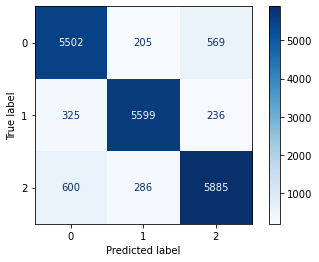

In [76]:
evaluate(output.best_estimator_, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

This model performed surprising well.

### Logistic Regression with PCA

Logistic Regression performe well, there could be a lot of multicollinearity issues driving its understanding. Therefore I will use Primary Component Analysis to reduce dimensionality and mulicolinearity. I tested to see how variance to explain.

In [24]:
pca_lr = Pipeline([
                    ('pca', PCA()), 
                    ('clr', LogisticRegression(max_iter=1000, 
                                               solver= "newton-cg",
                                               penalty = "l2", 
                                               random_state=seed)
                    )])

In [25]:
param_grid = {
    "pca__n_components" : [.99]
}

In [26]:
grid = GridSearchCV(pca_lr, param_grid, return_train_score=True, cv = 3)

In [27]:
output = grid.fit(X_train_tfidf_vec_df, y_train)

In [28]:
output.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=0.99)),
                ('clr',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='newton-cg'))])

Accuracy Score:
Train - 0.9
Test - 0.882490758577602
  
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6276
           1       0.92      0.91      0.91      6160
           2       0.88      0.87      0.87      6771

    accuracy                           0.88     19207
   macro avg       0.88      0.88      0.88     19207
weighted avg       0.88      0.88      0.88     19207

Confusion matrix for test data


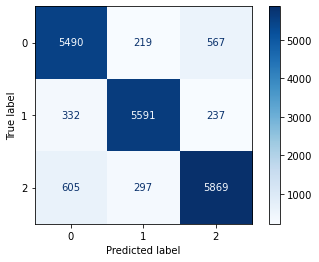

In [31]:
evaluate(output.best_estimator_, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

This model peformed slightly better than logistic regression without PCA.

### Decision Tree

For the decision tree I decided to explore the depth of the tree, how many samples in each leaf and how many samples to split at internal node. I adjusted these features because the previous model was very overfit.

In [32]:
dt_tuned = Pipeline(steps=[
    ('clf', DecisionTreeClassifier(random_state=seed)),
])
dt_tuned

Pipeline(steps=[('clf', DecisionTreeClassifier(random_state=42))])

In [33]:
param_grid = {
    'clf__max_depth': [25],
    'clf__min_samples_leaf': [10],
    'clf__min_samples_split': [5],
}

In [34]:
grid = GridSearchCV(dt_tuned, param_grid, return_train_score=True,cv =3)

In [35]:
output = grid.fit(X_train_tfidf_vec_df, y_train)

In [36]:
output.best_estimator_

Pipeline(steps=[('clf',
                 DecisionTreeClassifier(max_depth=25, min_samples_leaf=15,
                                        min_samples_split=3,
                                        random_state=42))])

Accuracy Score:
Train - 0.8521520305449497
Test - 0.7842973915759879
  
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      6276
           1       0.87      0.85      0.86      6160
           2       0.77      0.74      0.75      6771

    accuracy                           0.78     19207
   macro avg       0.79      0.79      0.79     19207
weighted avg       0.79      0.78      0.78     19207

Confusion matrix for test data


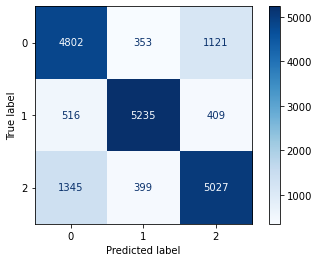

In [37]:
evaluate(output.best_estimator_, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

While less overfit, the model is not performing as well as others.

### Support Vector Machine - SVM

SVMs are known to be good for text classification projects. I decided to go with SGDClassifier. This model uses a “one versus all” (OVA) scheme between the classes. 

In [70]:
svm_tuned = Pipeline(steps=[
    ('clf', SGDClassifier(random_state=seed)),
])
svm_tuned

Pipeline(steps=[('clf', SGDClassifier(random_state=42))])

In [71]:
param_grid = {
    "clf__loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "clf__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "clf__penalty" : ["l2", "l1", "elasticnet", "none"],
}

In [72]:
grid = GridSearchCV(svm_tuned, param_grid, return_train_score=True, cv = 3)

In [ ]:
output = grid.fit(X_train_tfidf_vec_df, y_train)

C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [ ]:
output.best_estimator_

In [ ]:
evaluate(output.best_estimator_, X_train_tfidf_vec_df, y_train, X_val_tfidf_vec_df, y_val)

This model is fit perfectly but does not perform as well

### Neural Network

This neural network will use the GLoVe embedding from Stanford NLP.

In [46]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath, encoding="UTF-8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [47]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [48]:
#will use for padding the corpus
max_length = max([len(s.split()) for s in X_train["processed_content"]])
max_length

6714

In [53]:
#tokenizes and vectorizes the words
tokenizer = keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(X_train["processed_content"])

X_train_token = tokenizer.texts_to_sequences(X_train["processed_content"])
X_val_token = tokenizer.texts_to_sequences(X_val["processed_content"])

In [54]:
# Length of vocab+1 because python starts in 0
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

157205


In [55]:
#pads the corpus
X_train_processed = keras.preprocessing.sequence.pad_sequences(
    X_train_token, maxlen=max_length, padding='post')
X_val_processed = keras.preprocessing.sequence.pad_sequences(
    X_val_token, maxlen=max_length, padding='post')

In [58]:
#similar to one hot encoding in sklearn
y_train2 = to_categorical(y_train)
y_val2 = to_categorical(y_val)

In [59]:
#create embedding dictionary for first layer
embedding_dim = 50
embedding_matrix = create_embedding_matrix('../data/glove.6B.50d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

In [60]:
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=False)) # Note - not retraining the embedding layer
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(layers.Dense(3, activation='softmax')) #three for the number of output

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 6714, 50)          7860250   
_________________________________________________________________
flatten (Flatten)            (None, 335700)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1007103   
Total params: 8,867,353
Trainable params: 1,007,103
Non-trainable params: 7,860,250
_________________________________________________________________


In [61]:
#
history = model.fit(X_train_processed, y_train2,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_val_processed, y_val2))

Epoch 1/10
577/577 [==============================] - 63s 110ms/step - loss: 1.0848 - accuracy: 0.6256 - val_loss: 1.2782 - val_accuracy: 0.6110
Epoch 2/10
577/577 [==============================] - 62s 107ms/step - loss: 0.6711 - accuracy: 0.7508 - val_loss: 1.3177 - val_accuracy: 0.6344
Epoch 3/10
577/577 [==============================] - 61s 106ms/step - loss: 0.5502 - accuracy: 0.7961 - val_loss: 1.4332 - val_accuracy: 0.6362
Epoch 4/10
577/577 [==============================] - 62s 107ms/step - loss: 0.5023 - accuracy: 0.8108 - val_loss: 1.5581 - val_accuracy: 0.6399
Epoch 5/10
577/577 [==============================] - 74s 129ms/step - loss: 0.4542 - accuracy: 0.8272 - val_loss: 1.8043 - val_accuracy: 0.6300
Epoch 6/10
577/577 [==============================] - 74s 129ms/step - loss: 0.4197 - accuracy: 0.8413 - val_loss: 1.8562 - val_accuracy: 0.6294
Epoch 7/10
577/577 [==============================] - 77s 134ms/step - loss: 0.3961 - accuracy: 0.8502 - val_loss: 1.9857 - val_ac

In [ ]:
visualize_training_results(history)

## Evaluation/Final Model

- Chosen model
    - why?
- holdout set
- May consider factors besides metrics, such as runtime, explainability, parsimony, or ease of use
- metric based on context of problem and consequences of errors
- Performance on holdout test data
- Implicatiosn of final model
    - how does it solve real world problem stated before